In [1]:
import h5py
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
SEED = 42

In [3]:
dataset_full = h5py.File('../data/Scratch-1700591575.7427056-all-embeddings.h5', 'r')

In [4]:
indices_pd = {}
for i in range(len(dataset_full['domains'])):
    if int(dataset_full['domains'][i]) in indices_pd:
        indices_pd[int(dataset_full['domains'][i])].append(i)
    else:
        indices_pd[int((dataset_full['domains'][i]))] = [i]

In [5]:
{len(v) for k, v in indices_pd.items()}

{34904, 59436, 85054, 129838, 146722}

In [6]:
indices_ss = {k: np.random.choice(v, 2_000, replace=False) for k, v in indices_pd.items()}

In [12]:
{k: len(v) for k, v in indices_ss.items()}

{0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000}

In [19]:
indices = sorted(np.concatenate([v for _,v in indices_ss.items()]))

In [20]:
embeddings, domains = dataset_full['embeddings'][indices], dataset_full['domains'][indices]

(array([2000.,    0., 2000.,    0.,    0., 2000.,    0., 2000.,    0.,
        2000.]),
 array([0.        , 0.40000001, 0.80000001, 1.20000005, 1.60000002,
        2.        , 2.4000001 , 2.79999995, 3.20000005, 3.5999999 ,
        4.        ]),
 <BarContainer object of 10 artists>)

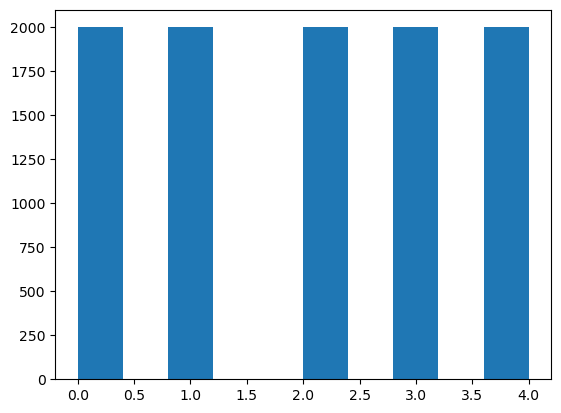

In [21]:
plt.hist(domains)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, domains, test_size=0.2, random_state=SEED)

In [23]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [24]:
clf = LogisticRegression(random_state=SEED, max_iter=10_000).fit(scaler.transform(X_train), y_train)

In [25]:
clf.score(scaler.transform(X_test), y_test)

0.5385

In [33]:
y_pred = clf.predict(scaler.transform(X_test))

In [34]:
y_pred

array([1., 0., 1., ..., 2., 2., 2.], dtype=float32)

In [35]:
len(y_pred), len(y_test)

(2000, 2000)

(array([397.,   0., 414.,   0.,   0., 396.,   0., 412.,   0., 381.]),
 array([0.        , 0.40000001, 0.80000001, 1.20000005, 1.60000002,
        2.        , 2.4000001 , 2.79999995, 3.20000005, 3.5999999 ,
        4.        ]),
 <BarContainer object of 10 artists>)

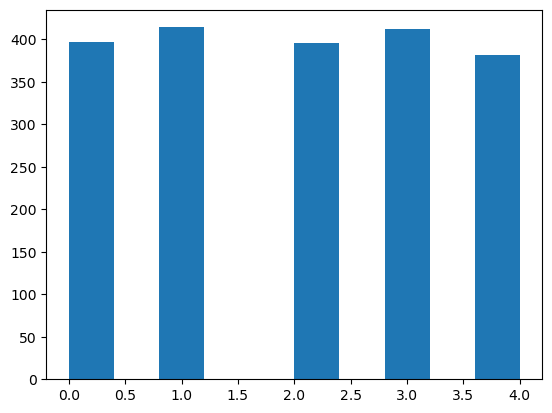

In [36]:
plt.hist(y_test)

(array([389.,   0., 405.,   0.,   0., 362.,   0., 451.,   0., 393.]),
 array([0.        , 0.40000001, 0.80000001, 1.20000005, 1.60000002,
        2.        , 2.4000001 , 2.79999995, 3.20000005, 3.5999999 ,
        4.        ]),
 <BarContainer object of 10 artists>)

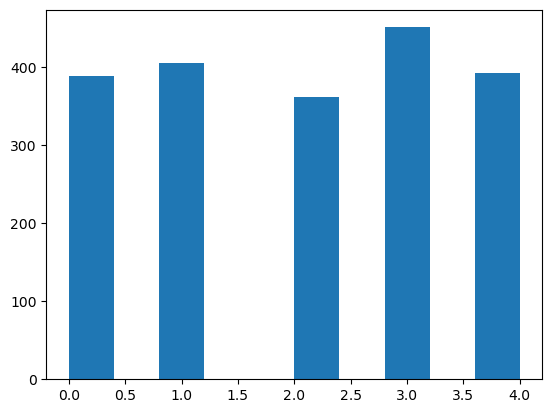

In [37]:
plt.hist(y_pred)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.41      0.40      0.40       397
         1.0       0.60      0.59      0.59       414
         2.0       0.59      0.54      0.56       396
         3.0       0.54      0.59      0.57       412
         4.0       0.56      0.58      0.57       381

    accuracy                           0.54      2000
   macro avg       0.54      0.54      0.54      2000
weighted avg       0.54      0.54      0.54      2000



In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [46]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', kernel='linear'))])

In [51]:
clf.score(X_test, y_test)

0.513

In [52]:
y_pred = clf.predict(X_test)

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.37      0.46      0.41       397
         1.0       0.58      0.59      0.59       414
         2.0       0.53      0.46      0.49       396
         3.0       0.53      0.53      0.53       412
         4.0       0.60      0.51      0.55       381

    accuracy                           0.51      2000
   macro avg       0.52      0.51      0.52      2000
weighted avg       0.52      0.51      0.52      2000

